In [1]:
import pandas as pd
import math
from pprint import pprint
import geopandas as gpd
from shapely.geometry import Polygon
import random
from operator import itemgetter
import numpy
import matplotlib
import matplotlib.pyplot
import numpy as np
import folium

In [2]:
uneheure = 100

# Read the CSV file into a DataFrame
df_regularite = pd.read_csv("regularite-mensuelle-tgv-aqst.csv", delimiter=';')
df_referentiel = pd.read_csv("referentiel-gares-voyageurs.csv", delimiter=';')

point_de_ref = "PARIS"

cities = {
    "PARIS": (48.856613, 2.352222),
    "MARSEILLE": (43.296482, 5.36978),
    "LYON": (45.764043, 4.835659),
    "TOULOUSE": (43.604652, 1.444209),
    "NICE": (43.7031, 7.26608),
    "NANTES": (47.218371, -1.553621),
    "STRASBOURG": (48.573405, 7.75211),
    "MONTPELLIER": (43.610769, 3.876716),
    "BORDEAUX": (44.837789, -0.57918),
    "LILLE": (50.62925, 3.057256),
    "METZ": (49.133333, 6.166667),
    "RENNES": (48.113461, -1.677908),
    "REIMS": (49.258329, 4.031696),
    "GRENOBLE": (45.188529, 5.724524),
    "ANGERS": (47.478419, -0.563166),
}

In [3]:
def define_vect_co(co1, co2):
    return (co2[0] - co1[0], co2[1] - co1[1])


def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # radius of Earth in kilometers
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


def get_temps_traj_ville(ville_depart, ville_arrive):
    for index in range(len(df_regularite["Gare de départ"])):
        gare_depart = df_regularite["Gare de départ"][index]
        gare_arrive = df_regularite["Gare d'arrivée"][index]
        if gare_depart == "PARIS LYON":
            gare_depart = "PARIS"
        if gare_arrive == "PARIS LYON":
            gare_arrive = "PARIS"
        if ville_depart in df_regularite["Gare de départ"][index] and ville_arrive in df_regularite["Gare d'arrivée"][
            index] and df_regularite["Date"][index] == "2022-11":
            return df_regularite["Durée moyenne du trajet"][index]


#print(get_temps_traj_ville("REIMS", "PARIS"))

def reduction_vect_trajet(echelle, ville1, ville2):
    co1 = cities[ville1]
    co2 = cities[ville2]
    vect_geogrphique = define_vect_co(co1, co2)
    temps_traj = get_temps_traj_ville(ville1, ville2)
    dist_traj = haversine(co1[1], co1[0], co2[1], co2[0])
    time_in_distance = (temps_traj / 60) * echelle
    coef = dist_traj / time_in_distance
    vect_temps = vect_geogrphique / coef
    return vect_temps


cit_cop = cities.copy()


def generate_reducted_dico(echelle, referenciel):
    dico_reduce = {}
    for key, value in cit_cop.items():
        try:
            if key != referenciel:
                print(key)
                print(reduction_vect_trajet(echelle, key, referenciel))
                dico_reduce[key] = tuple(cit_cop[referenciel] - reduction_vect_trajet(echelle, key, referenciel))
        except:
            print("ERROR ", key)
            cities.pop(key)

    return dico_reduce


dico_decaler = (generate_reducted_dico(uneheure, point_de_ref))

MARSEILLE
[ 2.77804312 -1.50768143]
LYON
[ 1.55355107 -1.24755339]
TOULOUSE
[4.07792775 0.70503406]
NICE
[ 4.39506663 -4.19068184]
NANTES
[1.09139919 2.60207827]
STRASBOURG
[ 0.13780078 -2.6274286 ]
MONTPELLIER
[ 3.04198784 -0.88403167]
BORDEAUX
[1.97198423 1.43840052]
LILLE
[-0.98715994 -0.39262484]
METZ
[-0.14332243 -1.97562714]
RENNES
[0.41786411 2.26608647]
REIMS
[-0.23641687 -0.98839974]
GRENOBLE
[ 2.26121445 -2.0788777 ]
ANGERS
[0.85817623 1.81535885]


In [4]:
class Create_random_polygon:

    def __init__(self, array, min_rand_coord=None, max_rand_coord=None, points_num=None):
        self.array = array
        self.min_rand_coord = min_rand_coord
        self.max_rand_coord = max_rand_coord
        self.points_num = points_num

    def generate_random_points(self):
        random_coords_list = []
        for x in range(self.points_num):
            coords_tuple = (random.randint(self.min_rand_coord, self.max_rand_coord),
                            random.randint(self.min_rand_coord, self.max_rand_coord))
            random_coords_list.append(coords_tuple)
        self.array = random_coords_list
        return random_coords_list

    def close_line_to_polygon(self):
        a = self.array[0]
        b = self.array[len(self.array) - 1]
        if a == b:
            pass
        else:
            self.array.append(a)

    def find_leftmost_point(self):
        leftmost_point = None
        leftmost_x = None
        for point in self.array:
            x = point[0]
            if leftmost_x == None or x < leftmost_x:
                leftmost_x = x
                leftmost_point = point
        return leftmost_point

    def find_rightmost_point(self):
        rightmost_point = None
        rightmost_x = None
        for point in self.array:
            x = point[0]
            if rightmost_x == None or x > rightmost_x:
                rightmost_x = x
                rightmost_point = point
        return rightmost_point

    def is_point_above_the_line(self, point, line_points):
        """return 1 if point is above the line
           return -1 if point is below the line
           return  0 if point is lays on the line"""
        px, py = point
        P1, P2 = line_points
        P1x, P1y = P1[0], P1[1]
        P2x, P2y = P2[0], P2[1]
        array = numpy.array([
            [P1x - px, P1y - py],
            [P2x - px, P2y - py],
        ])
        det = numpy.linalg.det(array)
        sign = numpy.sign(det)
        return sign

    def sort_array_into_A_B_C(self, line_points):
        [(x_lm, y_lm), (x_rm, y_rm)] = line_points
        A_array, B_array, C_array = [], [], []
        for point in self.array:
            x, y = point
            sing = self.is_point_above_the_line((x, y), line_points)
            if sing == 0:
                C_array.append(point)
            elif sing == -1:
                A_array.append(point)
            elif sing == 1:
                B_array.append(point)
        return A_array, B_array, C_array

    def sort_and_merge_A_B_C_arrays(self, A_array, B_array, C_array):
        A_C_array = [*A_array, *C_array]
        A_C_array.sort(key=itemgetter(0))
        B_array.sort(key=itemgetter(0), reverse=True)
        merged_arrays = [*A_C_array, *B_array]
        self.array = merged_arrays

    def show_image(self, array, line_points, A_array, B_array, C_array):
        [(x_lm, y_lm), (x_rm, y_rm)] = line_points
        x = [x[0] for x in array]
        y = [y[1] for y in array]
        Ax = [x[0] for x in A_array]
        Ay = [y[1] for y in A_array]
        Bx = [x[0] for x in B_array]
        By = [y[1] for y in B_array]
        Cx = [x[0] for x in C_array]
        Cy = [y[1] for y in C_array]
        matplotlib.pyplot.plot(Ax, Ay, 'o', c='orange')  # below the line
        matplotlib.pyplot.plot(Bx, By, 'o', c='blue')  # above the line
        matplotlib.pyplot.plot(Cx, Cy, 'o', c='black')  # on the line
        matplotlib.pyplot.plot(x_lm, y_lm, 'o', c='green')  # leftmost point
        matplotlib.pyplot.plot(x_rm, y_rm, 'o', c='red')  # rightmost point
        x_plot = matplotlib.pyplot.plot([x_lm, x_rm], [y_lm, y_rm], linestyle=':', color='black',
                                        linewidth=0.5)  # polygon's division line
        x_plot = matplotlib.pyplot.plot(x, y, color='black',
                                        linewidth=1)  # connect points by line in order of apperiance
        matplotlib.pyplot.show()

    def main(self, plot=False):
        'First output is random polygon coordinates array (other stuff for ploting)'
        #print(self.array)
        if self.array == None:
            if not all(
                    [isinstance(min_rand_coord, int),
                     isinstance(max_rand_coord, int),
                     isinstance(points_num, int), ]
            ):
                print('Error! Values must be "integer" type:', 'min_rand_coord =', min_rand_coord, ', max_rand_coord =',
                      max_rand_coord, ', points_num =', points_num)
            else:
                self.array = self.generate_random_points()

        #print(self.array)
        x_lm, y_lm = self.find_leftmost_point()
        x_rm, y_rm = self.find_rightmost_point()
        line_points = [(x_lm, y_lm), (x_rm, y_rm)]

        A_array, B_array, C_array = self.sort_array_into_A_B_C(line_points)
        self.sort_and_merge_A_B_C_arrays(A_array, B_array, C_array)
        self.close_line_to_polygon()
        if plot:
            self.show_image(self.array, line_points, A_array, B_array, C_array)
        return self.array


def polygon_gon_array(array: list):
    min_rand_coord = 1
    max_rand_coord = 10000
    points_num = 30

    crt = Create_random_polygon(array, min_rand_coord, max_rand_coord, points_num)
    return crt.main(plot=True)


In [5]:
#Clearing the data set
df_without_D = (df_referentiel[df_referentiel["Segment DRG"].str.contains("D") == False])
df_without_nan = (df_without_D[df_without_D["Segment DRG"].str.contains("NaN") == False])

In [6]:
#On récupére les longitude et latitude present dans le scv
list_longitude = (list(df_without_nan['Longitude']))
list_latitude = (list(df_without_nan['Latitude']))
#On nettoie les donneés
lat_point_list = (list(filter(lambda a: str(a) != "nan", list_latitude)))
lon_point_list = (list(filter(lambda a: str(a) != "nan", list_longitude)))

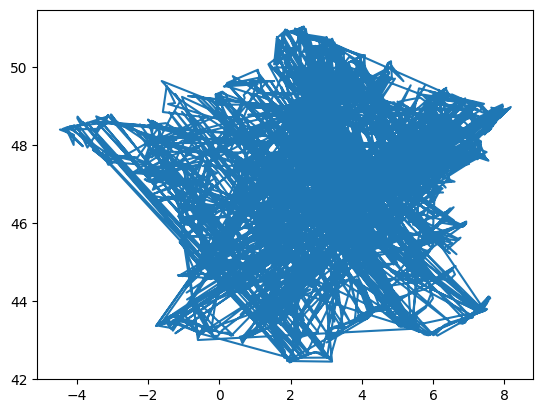

In [7]:
from matplotlib import pyplot as plt
coordOri = list(zip(lon_point_list,lat_point_list))
coord2disp = coordOri[:]
coord2disp.append(coord2disp[0]) #repeat the first point to create a 'closed loop'
xs, ys = zip(*coord2disp) #create lists of x and y values

plt.figure()
plt.plot(xs,ys)
plt.show()

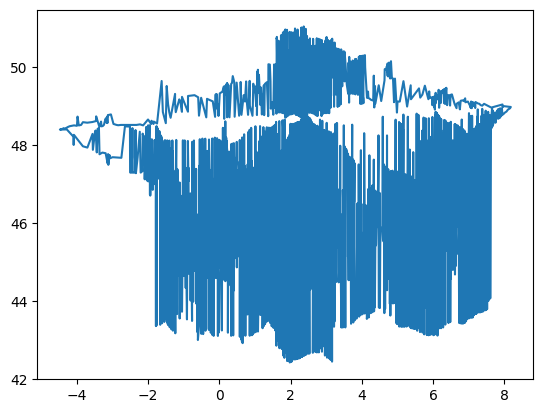

In [8]:
leftPoint = min(coordOri, key = lambda t: t[0])
rightPoint = max(coordOri, key = lambda t: t[0])

a = (rightPoint[1]-leftPoint[1])/(rightPoint[0]-leftPoint[0])
b=leftPoint[1]-a*leftPoint[0]

def isAbove(point):
    return point[1] > (a*point[0]+b)



above = list(filter(lambda point: isAbove(point), coordOri))
below = list(filter(lambda point: not(isAbove(point)), coordOri))
above.sort(key = lambda x: x[0])
below.sort(key = lambda x: x[0],reverse=True)
coord = above+below

coord2disp = coord[:]
coord2disp.append(coord2disp[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord2disp) #create lists of x and y values

plt.figure()
plt.plot(xs,ys)
plt.show()

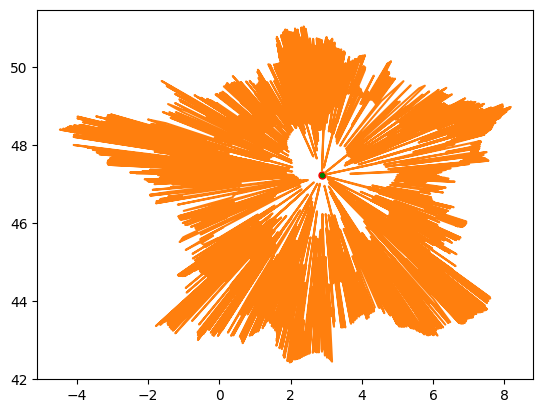

In [9]:
xc = sum([point[0] for point in coordOri])/len(coordOri)
yc = sum([point[1] for point in coordOri])/len(coordOri)
coord = coordOri[:]
coord.sort(key = lambda x: math.atan2((x[1]-yc), (x[0]-xc)))
angles = [math.atan((x[1]-yc)/(x[0]-xc)) for x in coord]

coordDisp = coord[:]
coordDisp.append(coordDisp[0]) #repeat the first point to create a 'closed loop'
xs, ys = zip(*coordDisp) #create lists of x and y values

plt.figure()
plt.plot([xc],[yc], marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
plt.plot(xs,ys)
plt.show()
coo = [[yc][0],[xc][0]]


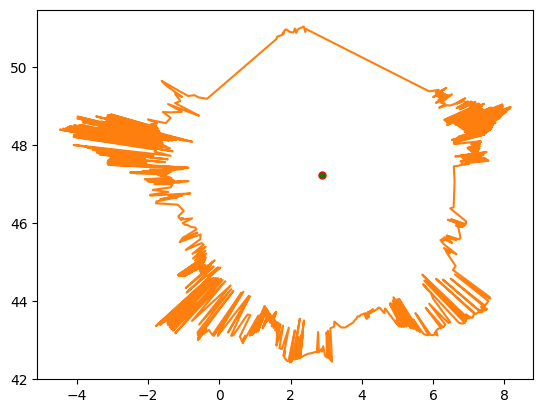

In [10]:
import math

dist = 3.7

def greaterThanCenter(point):
    return math.sqrt(math.pow(point[0]-xc,2) + math.pow(point[1]-yc,2)) > dist

coordDisp = list(filter(lambda point: greaterThanCenter(point), coord))

coordDisp.append(coordDisp[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coordDisp) #create lists of x and y values

plt.figure()
plt.plot([xc],[yc], marker="o", markersize=5, markeredgecolor="red", markerfacecolor="green")
plt.plot(xs,ys)
plt.show()

In [11]:
coordinates = coordDisp

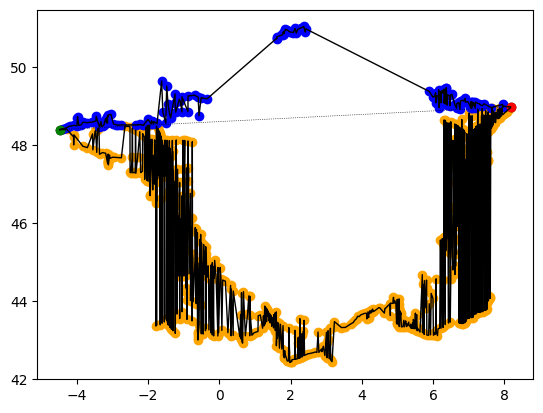

In [12]:
polygon_array_city = polygon_gon_array(coordinates)
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[Polygon(polygon_array_city)])

polygon.to_file(filename='polygon.geojson', driver='GeoJSON')
polygon.to_file(filename='polygon.gpkg', driver="GPKG")
polygon.to_file(filename='polygon.shp', driver="ESRI Shapefile")


# Coordonnées du point central
lat = cities[point_de_ref][0]
lon = cities[point_de_ref][1]

m = folium.Map([lat, lon], zoom_start=5, tiles='cartodbpositron')
folium.GeoJson(polygon).add_to(m)
folium.Marker(location=cities[point_de_ref], icon=folium.Icon(color='red')).add_to(m)
folium.Marker(location=coo, icon=folium.Icon(color='green')).add_to(m)
folium.LatLngPopup().add_to(m)
m

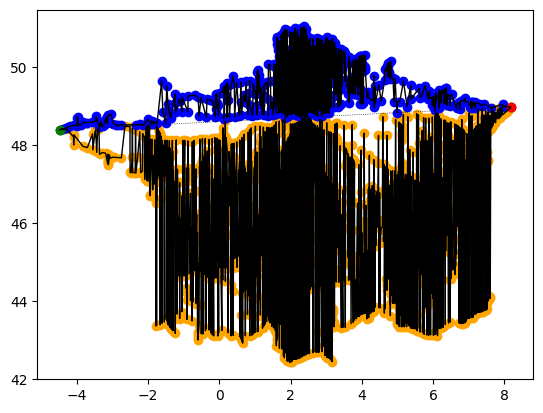

In [13]:
array = (list(zip(lon_point_list, lat_point_list)))

polygon_array = polygon_gon_array(array)

In [14]:
polygon_geom2 = Polygon(polygon_array)

In [15]:
cities_decaler = dico_decaler
res = []
for city, coords in cities_decaler.items():
    if (city != point_de_ref):
        x = (coords[1], coords[0])
        res.append(x)
poly_city = res

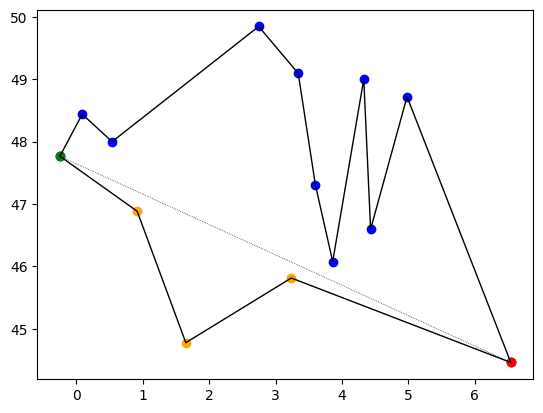

In [16]:
array = poly_city
polygon_array_city = polygon_gon_array(array)

In [17]:
res = [[], []]
for city, coords in cities.items():
    if (city != point_de_ref):
        x = (coords[0], coords[1])
        res[0].append(x)
for city, coords in cities_decaler.items():
    if (city != point_de_ref):
        x = (coords[0], coords[1])
        res[1].append(x)

res

[[(43.296482, 5.36978),
  (45.764043, 4.835659),
  (43.604652, 1.444209),
  (43.7031, 7.26608),
  (47.218371, -1.553621),
  (48.573405, 7.75211),
  (43.610769, 3.876716),
  (44.837789, -0.57918),
  (50.62925, 3.057256),
  (49.133333, 6.166667),
  (48.113461, -1.677908),
  (49.258329, 4.031696),
  (45.188529, 5.724524),
  (47.478419, -0.563166)],
 [(46.07856987713465, 3.8599034286834835),
  (47.303061934922226, 3.599775392939711),
  (44.7786852533887, 1.6471879361553206),
  (44.46154636842285, 6.542903837439516),
  (47.76521380537478, -0.24985626715012677),
  (48.71881221622406, 4.979650599129609),
  (45.81462515931423, 3.2362536660576273),
  (46.88462877077246, 0.9138214844446833),
  (49.8437729382093, 2.7448468407742004),
  (48.999935433892105, 4.327849136988875),
  (48.43874888905971, 0.08613553394219453),
  (49.09302987097726, 3.3406217350557634),
  (46.595398548609886, 4.4310996965990395),
  (47.99843677224819, 0.5368631490161022)]]

In [18]:
pprint(polygon_geom2)
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[Polygon(polygon_array_city)])

polygon.to_file(filename='polygon.geojson', driver='GeoJSON')
polygon.to_file(filename='polygon.gpkg', driver="GPKG")
polygon.to_file(filename='polygon.shp', driver="ESRI Shapefile")

<POLYGON ((-4.479 48.388, -4.286 48.393, -4.094 48.202, -4.092 47.994, -4.08...>


In [19]:
# Coordonnées du point central
lat = cities[point_de_ref][0]
lon = cities[point_de_ref][1]
m = folium.Map([lat, lon], zoom_start=5, tiles='cartodbpositron')

In [20]:
# Ajout des cercles
folium.Circle(
    location=(lat, lon),
    radius=100000,
    color='blue',
    fill=False,
).add_to(m)

folium.Circle(
    location=(lat, lon),
    radius=200000,
    color='green',
    fill=False,
).add_to(m)

folium.Circle(
    location=(lat, lon),
    radius=300000,
    color='red',
    fill=False,
).add_to(m)

for k in range(len(res[0])):
    folium.PolyLine(
        locations=[res[1][k], res[0][k]],
        arrow=True,
        color='red',
        weight=2,
        opacity=1
    ).add_to(m)

In [21]:
for city, coords in cities.items():
    if (city != point_de_ref):
        folium.Marker(coords, popup=city).add_to(m)
for city, coords in cities_decaler.items():
    if (city != point_de_ref):
        folium.Marker(coords, popup=city, icon=folium.Icon(color='green')
                      ).add_to(m)

folium.GeoJson(polygon).add_to(m)
folium.Marker(location=cities[point_de_ref], icon=folium.Icon(color='red')).add_to(m)
folium.LatLngPopup().add_to(m)
#m.save("map.html")
m